# FLiES-ANN Sensitivity Analysis with ECOv002 Cal-Val

This notebook performs a sensitivity analysis of the FLiES-ANN model using ECOSTRESS Collection 2 Cal-Val data. It loads input data, processes it through the FLiES-ANN model, and visualizes the impact of input perturbations on latent heat flux. The notebook also generates figures for publication and explores the relationship between surface temperature and latent heat flux.

## Import Required Libraries and Functions

This cell imports all necessary libraries and functions for data processing, model execution, statistical analysis, and plotting. It includes custom modules for the BESS-JPL model, sensitivity analysis, and net radiation calculations, as well as standard scientific Python libraries.

In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))

In [2]:
from typing import Callable
from os import makedirs
from os.path import join
import numpy as np
import pandas as pd
from FLiESANN import process_FLiESANN_table, load_ECOv002_calval_FLiESANN_inputs
from monte_carlo_sensitivity import perturbed_run, sensitivity_analysis, divide_absolute_by_unperturbed
import matplotlib.pyplot as plt
from scipy.stats import mstats
import seaborn as sns
from matplotlib.ticker import FuncFormatter

[2025-11-04 15:17:08 INFO] SRTM working directory: ~/data/NASADEM
[2025-11-04 15:17:08 INFO] SRTM download directory: ~/data/NASADEM
[2025-11-04 15:17:08 INFO] SRTM download directory: ~/data/NASADEM


## Set Normalization Function

This cell assigns the normalization function used to compare perturbed model outputs to the unperturbed baseline. The function `divide_absolute_by_unperturbed` is used for normalization in the sensitivity analysis.

In [3]:
normalization_function = divide_absolute_by_unperturbed

## Load and Filter Input Data

This cell loads the ECOSTRESS Cal-Val input data using a custom loader function. The resulting DataFrame is displayed for inspection.

In [4]:
input_df = load_ECOv002_calval_FLiESANN_inputs()
input_df

,Unnamed: 0,ID,vegetation,climate,STICinst,BESSinst,MOD16inst,PTJPLSMinst,ETinst,ETinstUncertainty,...,PAR_diffuse_fraction,NIR_diffuse_fraction,SWin_TOA_Wm2,UV_Wm2,PAR_Wm2,NIR_Wm2,PAR_diffuse_Wm2,NIR_diffuse_Wm2,PAR_direct_Wm2,NIR_direct_Wm2
0,0,US-NC3,ENF,Cfa,270.345200,78.53355,392.851840,307.021970,487.383423,118.916280,...,0.331442,0.126795,[884.3206],[37.19775],[297.09644],[301.6259],[98.47026],[38.244507],[198.62617],[263.38138]
1,1,US-Mi3,CVM,Dfb,232.141600,229.20093,640.118470,375.089300,106.825577,167.919460,...,0.077509,0.000000,[1199.2876],[61.88242],[448.3309],[504.05743],[34.749718],[0.],[413.58118],[504.05743]
2,2,US-Mi3,CVM,Dfb,356.355740,335.23154,625.661700,284.686250,NaN,132.936340,...,0.135801,0.020261,[1205.0444],[59.888546],[445.1997],[478.15152],[60.458534],[9.687695],[384.74118],[468.46384]
3,3,US-Mi3,CVM,Dfb,332.938400,326.68680,624.254330,251.414490,178.827545,141.132420,...,0.082276,0.004152,[1142.2208],[57.06719],[418.59457],[464.9589],[34.440193],[1.9305093],[384.1544],[463.02838]
4,4,US-Mi3,CVM,Dfb,286.854030,237.21654,511.082180,228.520170,154.791626,114.809410,...,0.125559,0.036793,[1042.2742],[49.48496],[368.71323],[398.33893],[46.29534],[14.656272],[322.41788],[383.68265]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1060,1060,US-xAE,GRA,Cfa,70.923310,172.37459,81.645230,15.282976,NaN,56.385185,...,0.160295,0.049838,[494.39365],[18.295532],[160.34612],[192.88585],[25.702702],[9.61307],[134.64342],[183.27278]
1061,1061,US-xAE,GRA,Cfa,116.543190,121.81641,65.469320,22.186659,NaN,40.509410,...,0.230560,0.085713,[527.2576],[19.551722],[170.03662],[193.2959],[39.203648],[16.567942],[130.83298],[176.72795]
1062,1062,US-xAE,GRA,Cfa,129.880100,0.00000,118.777240,55.343586,NaN,52.403820,...,0.193641,0.059828,[576.76715],[22.72433],[191.89697],[219.24944],[37.15915],[13.117284],[154.73782],[206.13216]
1063,1063,US-xAE,GRA,Cfa,2.707851,140.38632,126.490524,40.434025,NaN,57.769722,...,0.176737,0.038771,[691.65015],[29.71815],[236.26799],[272.9652],[41.757275],[10.5832405],[194.51071],[262.38196]


In [5]:
list(input_df.columns)

['Unnamed: 0',
 'ID',
 'vegetation',
 'climate',
 'STICinst',
 'BESSinst',
 'MOD16inst',
 'PTJPLSMinst',
 'ETinst',
 'ETinstUncertainty',
 'PET',
 'Rn',
 'ESI',
 'RH',
 'Ta',
 'LST',
 'SM',
 'NDVI',
 'NDVI-UQ',
 'albedo',
 'albedo-UQ',
 'LST_err',
 'view_zenith',
 'Rg',
 'EmisWB',
 'time_utc',
 'solar_time',
 'solar_hour',
 'local_time',
 'LE',
 'LE_filt',
 'LEcorr25',
 'LEcorr50',
 'LEcorr75',
 'LEcorr_ann',
 'H_filt',
 'Hcorr25',
 'Hcorr50',
 'Hcorr75',
 'Hcorr_ann',
 'NETRAD_filt',
 'G_filt',
 'SM_surf',
 'SM_rz',
 'AirTempC',
 'SW_IN',
 'RH_percentage',
 'ESIrn_STIC',
 'ESIrn_PTJPLSM',
 'ESIrn_MOD16',
 'ESIrn_BESS',
 'ESIrn_Unc_ECO',
 'ESIrn_LEcorr50',
 'JET',
 'eco_time_utc',
 'Site Name',
 'Date-Time',
 'Site ID',
 'Name',
 'Lat',
 'Long',
 'Elev',
 'Clim',
 'Veg',
 'MAT',
 'MAP',
 'StartDate',
 'EndDate',
 'LE_count',
 'closure_ratio',
 'geometry',
 'elevation_m',
 'time_UTC',
 'ST_K',
 'ST_C',
 'Ta_C',
 'SWin_Wm2',
 'emissivity',
 'insitu_LE_Wm2',
 'insitu_H_Wm2',
 'insitu_Rn_W

## Process Input Data Through Model

This cell applies the processing function to the filtered input data, running it through the Verma net radiation and PT-JPL-SM model, and displays the resulting DataFrame.

In [6]:
processed = process_FLiESANN_table(input_df)
processed

[2025-11-04 15:17:08 INFO] started processing FLiES input table
[2025-11-04 15:17:08 INFO] processing table in vectorized mode
[2025-11-04 15:17:08 INFO] processing 1065 rows in vectorized mode
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
[2025-11-04 15:17:08 INFO] completed processing FLiES input table


,Unnamed: 0,ID,vegetation,climate,STICinst,BESSinst,MOD16inst,PTJPLSMinst,ETinst,ETinstUncertainty,...,PAR_diffuse_fraction,NIR_diffuse_fraction,SWin_TOA_Wm2,UV_Wm2,PAR_Wm2,NIR_Wm2,PAR_diffuse_Wm2,NIR_diffuse_Wm2,PAR_direct_Wm2,NIR_direct_Wm2
0,0,US-NC3,ENF,Cfa,270.345200,78.53355,392.851840,307.021970,487.383423,118.916280,...,0.331442,0.126794,884.320618,37.197750,297.096436,301.625885,98.470253,38.244499,198.626190,263.381378
1,1,US-Mi3,CVM,Dfb,232.141600,229.20093,640.118470,375.089300,106.825577,167.919460,...,0.077509,0.000000,1199.287598,61.882423,448.330933,504.057434,34.749706,0.000000,413.581238,504.057434
2,2,US-Mi3,CVM,Dfb,356.355740,335.23154,625.661700,284.686250,NaN,132.936340,...,0.135801,0.020261,1205.044434,59.888542,445.199707,478.151550,60.458492,9.687667,384.741211,468.463898
3,3,US-Mi3,CVM,Dfb,332.938400,326.68680,624.254330,251.414490,178.827545,141.132420,...,0.082276,0.004152,1142.220825,57.067181,418.594543,464.958832,34.440212,1.930551,384.154327,463.028290
4,4,US-Mi3,CVM,Dfb,286.854030,237.21654,511.082180,228.520170,154.791626,114.809410,...,0.125559,0.036793,1042.274170,49.484959,368.713165,398.338959,46.295307,14.656249,322.417847,383.682709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1060,1060,US-xAE,GRA,Cfa,70.923310,172.37459,81.645230,15.282976,NaN,56.385185,...,0.160295,0.049838,494.393646,18.295530,160.346069,192.885818,25.702677,9.613062,134.643387,183.272751
1061,1061,US-xAE,GRA,Cfa,116.543190,121.81641,65.469320,22.186659,NaN,40.509410,...,0.230560,0.085713,527.257629,19.551722,170.036652,193.295929,39.203659,16.567940,130.832993,176.727997
1062,1062,US-xAE,GRA,Cfa,129.880100,0.00000,118.777240,55.343586,NaN,52.403820,...,0.193641,0.059828,576.767151,22.724331,191.896942,219.249435,37.159142,13.117271,154.737793,206.132172
1063,1063,US-xAE,GRA,Cfa,2.707851,140.38632,126.490524,40.434025,NaN,57.769722,...,0.176737,0.038771,691.650146,29.718149,236.268005,272.965210,41.757259,10.583200,194.510742,262.382019


## Accuracy Comparison of In-Situ Solar Radiation to FLiES-ANN Solar Radiation

/var/folders/hk/35_x93nx79vg1zmd2fy1vcbr0000gq/T/ipykernel_61351/1575319001.py:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = plt.scatter(


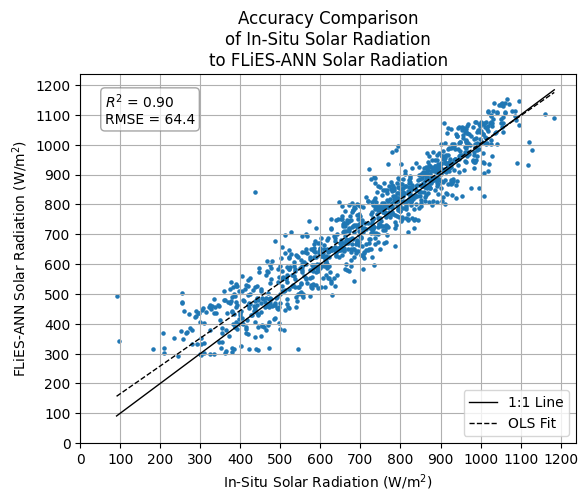

In [7]:
sc = plt.scatter(
    x=processed.insitu_SWin_Wm2,
    y=processed.SWin_Wm2,
    # c=processed.ST_C,
    cmap="jet",
    color=None,
    s=5
)

# Add 1-to-1 line
min_val = min(processed.insitu_SWin_Wm2.min(), processed.SWin_Wm2.min())
max_val = max(processed.insitu_SWin_Wm2.max(), processed.SWin_Wm2.max())
plt.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='-', linewidth=1, label='1:1 Line')

# Filter out NaN or infinite values
valid_data = processed.dropna(subset=["insitu_SWin_Wm2", "SWin_Wm2"])
valid_data = valid_data[np.isfinite(valid_data["insitu_SWin_Wm2"]) & np.isfinite(valid_data["SWin_Wm2"])]

# Add OLS regression line
if len(valid_data) > 1:  # Ensure there are enough points for regression
    coefs = np.polyfit(valid_data.insitu_SWin_Wm2, valid_data.SWin_Wm2, 1)
    ols_x = np.array([min_val, max_val])
    ols_y = coefs[0] * ols_x + coefs[1]
    plt.plot(ols_x, ols_y, color='black', linestyle='--', linewidth=1, label='OLS Fit')

    # Calculate R-squared and RMSE
    from sklearn.metrics import r2_score, mean_squared_error
    y_true = valid_data.SWin_Wm2
    y_pred = coefs[0] * valid_data.insitu_SWin_Wm2 + coefs[1]
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    # Annotate R-squared and RMSE on plot
    plt.annotate(f"$R^2$ = {r2:.2f}\nRMSE = {rmse:.1f}",
                 xy=(0.05, 0.95), xycoords='axes fraction',
                 ha='left', va='top',
                 fontsize=10,
                 bbox=dict(boxstyle='round', fc='white', ec='gray', alpha=0.7))
else:
    print("Not enough valid data points for regression.")

# Set ticks every 100 for both axes
xticks = np.arange(100 * (min_val // 100), 100 * (max_val // 100 + 2), 100)
yticks = np.arange(100 * (min_val // 100), 100 * (max_val // 100 + 2), 100)
plt.xticks(xticks)
plt.yticks(yticks)

plt.grid(True, zorder=0) 
plt.xlabel("In-Situ Solar Radiation (W/m$^2$)")
plt.ylabel("FLiES-ANN Solar Radiation (W/m$^2$)")
plt.title("Accuracy Comparison\nof In-Situ Solar Radiation\nto FLiES-ANN Solar Radiation")
# plt.colorbar(sc, label="ECOSTRESS Surface Temperature (°C)")
plt.legend()
plt.savefig("Unperturbed Comparison of In-Situ Solar Radiation to FLiES-ANN Solar Radiation.jpeg", format='jpeg', bbox_inches='tight')
plt.savefig("Unperturbed Comparison of In-Situ Solar Radiation to FLiES-ANN Solar Radiation.svg", format='svg', bbox_inches='tight')
plt.show()

## Plot Unperturbed Comparison of Albedo to Net Radiation

This cell creates a scatter plot comparing STARS albedo to FLiESANN solar radiation for the unperturbed data. The plot is saved as both JPEG and SVG files for publication or further analysis.

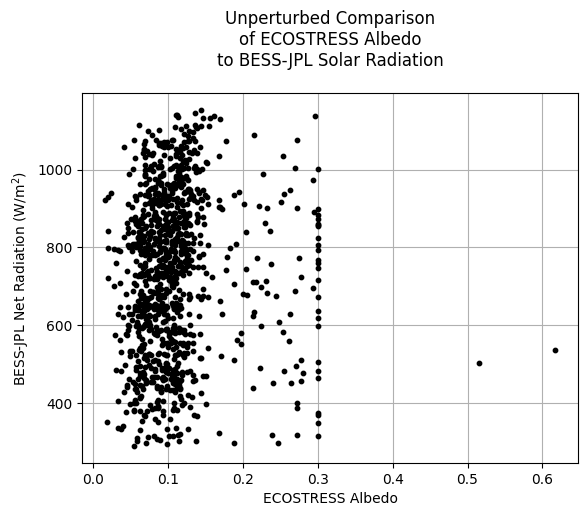

In [8]:
plt.scatter(x=processed.albedo, y=processed.SWin_Wm2, color='black', s=10, zorder=5)
plt.grid(True, zorder=0)
plt.xlabel("ECOSTRESS Albedo")
plt.ylabel("BESS-JPL Net Radiation (W/m$^2$)")
plt.title("Unperturbed Comparison\nof ECOSTRESS Albedo\nto BESS-JPL Solar Radiation", pad=20)

plt.savefig("Unperturbed Comparison of ECOSTRESS Albedo to BESS-JPL Solar Radiation.jpeg", format='jpeg', bbox_inches='tight')
plt.savefig("Unperturbed Comparison of ECOSTRESS Albedo to BESS-JPL Solar Radiation.svg", format='svg', bbox_inches='tight')

plt.show()

## Further Filter Input Data and Check Temperature Range

This cell applies additional filters to the input data, ensuring only valid `fAPARmax` and `NDVI` values are included. It also checks the minimum and maximum surface temperature values in the filtered dataset.

In [9]:
# input_df = pd.read_csv(input_filename)
input_df = load_ECOv002_calval_FLiESANN_inputs()

if "Ta" in input_df and "Ta_C" not in input_df:
    # input_df.rename({"Ta": "Ta_C"}, inplace=True)
    input_df["Ta_C"] = input_df["Ta"]

input_df = input_df[input_df.NDVI.apply(lambda NDVI: NDVI > 0.05)]

np.nanmin(input_df.albedo), np.nanmax(input_df.albedo)

(np.float64(0.015407953), np.float64(0.3))

## Check Number of Valid Input Rows

This cell displays the number of rows remaining in the input DataFrame after all filtering steps, confirming the size of the dataset used for analysis.

In [10]:
len(input_df)

1063

## Run Perturbed Model Analysis

This cell sets up the input and output variables for the sensitivity analysis and runs the `perturbed_run` function, which perturbs the input variable and observes the effect on the output variable using the BESS-JPL model. The results are displayed for further analysis.

In [11]:
input_variable = "albedo"
output_variable = "SWin_Wm2"

Rn_results = perturbed_run(
    input_df=input_df, 
    input_variable=input_variable, 
    output_variable=output_variable, 
    forward_process=process_FLiESANN_table,
    normalization_function=normalization_function
)

Rn_results

[2025-11-04 15:17:09 INFO] tarting Monte Carlo perturbed run
[2025-11-04 15:17:09 INFO] calculating standard deviation of input variable: albedo
[2025-11-04 15:17:09 INFO] input variable albedo standard deviation: 0.05366279984322165
[2025-11-04 15:17:09 INFO] starting forward process
[2025-11-04 15:17:09 INFO] started processing FLiES input table
[2025-11-04 15:17:09 INFO] processing table in vectorized mode
[2025-11-04 15:17:09 INFO] processing 1063 rows in vectorized mode
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
[2025-11-04 15:17:09 INFO] completed processing FLiES input table
[2025-11-04 15:17:09 INFO] forward process completed
[2025-11-04 15:17:09 INFO] calculating standard deviation of output variable: SWin_Wm2
[2025-11-04 15:17:09 INFO] output variable SWin_Wm2 standard deviation: 204.9628448486328
[2025-11-04 15:17:09 INFO] starting input perturbation generation
[2025-11-04 15:17:09 INFO] input perturbation generation completed
[2025-11-04 15:17:09 INFO] generating control group

ValueError: Invalid dtype: object

In [ ]:
input_variable = "albedo"
output_variable = "SWin_Wm2"

SWin_results = perturbed_run(
    input_df=input_df, 
    input_variable=input_variable, 
    output_variable=output_variable, 
    forward_process=process_FLiESANN_table,
    normalization_function=normalization_function
)

SWin_results

## Filter Out NaN Results

This cell removes any rows with missing values from the perturbed results to ensure only valid data points are used in subsequent analysis and plotting.

In [ ]:
filtered_SWin_results = SWin_results.dropna()
filtered_SWin_results

## Plot Change in Albedo vs. Solar Radiation

This cell generates a scatter plot showing the relationship between changes in STARS albedo and changes in FLiES-ANN solar radiation due to input perturbations. The plot is saved as JPEG and SVG files.

In [ ]:
# plt.xticks(range(int(min(processed.ST_C)), int(max(processed.ST_C)) + 1, 5))
# plt.ylim(-350, 150)
plt.scatter(x=Rn_results.input_perturbation, y=Rn_results.output_perturbation, color='black', s=10, zorder=5)  # Adjust the 's' parameter to make dots thinner
plt.grid(True, zorder=0)
plt.xlabel("Change in STARS Albedo")
plt.ylabel("Change in FLiES-ANN Solar Radiation (W/m$^2$)")
plt.title("Comparison of Change\nin STARS Albedo\nto FLiES-ANN Solar Radiation", pad=20)

plt.savefig("Comparison of Change in STARS Albedo to FLiES-ANN Solar Radiation.jpeg", format='jpeg', bbox_inches='tight')
plt.savefig("Comparison of Change in STARS Albedo to FLiES-ANN Solar Radiation.svg", format='svg', bbox_inches='tight')

plt.show()

In [ ]:
sc = plt.scatter(
    x=Rn_results.input_perturbation, 
    y=Rn_results.output_perturbation, 
    c=Rn_results.input_unperturbed, 
    color=None,
    cmap="jet",
    s=3,
    alpha=0.5, 
    zorder=5
)

plt.grid(True, zorder=0)
plt.xlabel("Change in STARS Albedo")
plt.ylabel("Change in FLiES-ANN Solar Radiation (W/m$^2$)")
plt.title("Comparison of Change\nin STARS Albedo\nto FLiES-ANN Solar Radiation", pad=20)
plt.colorbar(sc, label="STARS Albedo")
plt.savefig("Comparison of Change in STARS Albedo to FLiES-ANN Solar Radiation.jpeg", format='jpeg', bbox_inches='tight')
plt.savefig("Comparison of Change in STARS Albedo to FLiES-ANN Solar Radiation.svg", format='svg', bbox_inches='tight')

plt.show()

## Compute Correlation Between Input and Output Perturbations

This cell calculates the Pearson correlation coefficient between the standardized input and output perturbations, quantifying the strength of their linear relationship.

In [ ]:
correlation = mstats.pearsonr(
    np.array(filtered_SWin_results.input_perturbation_std).astype(np.float64), 
    np.array(filtered_SWin_results.output_perturbation_std).astype(np.float64)
)[0]

correlation

## Run Full Sensitivity Analysis for Multiple Inputs

This cell performs a comprehensive sensitivity analysis by perturbing several input variables (surface temperature, NDVI, albedo, air temperature, relative humidity) and measuring their effect on latent heat flux. The results are summarized in a DataFrame.

In [ ]:
input_variables = ["albedo"]
output_variables = ["SWin_Wm2"]

Rn_perturbation_df, Rn_sensitivity_metrics_df = sensitivity_analysis(
    input_df=input_df,
    input_variables=input_variables,
    output_variables=output_variables,
    forward_process=process_FLiESANN_table,
    normalization_function=normalization_function
)

Rn_sensitivity_metrics_df

## Plot Sensitivity Magnitude Bar Chart

This cell creates a bar chart showing the average percent change in latent heat flux for each input variable, visualizing the magnitude of model sensitivity to each input. The plot is saved as JPEG and SVG files with the BESS-JPL label.

In [ ]:
# df = Rn_sensitivity_metrics_df
# df = df[(df.output_variable == "SWin_Wm2") & (df.metric == "mean_normalized_change")]
# ax = sns.barplot(x=df.input_variable, y=df.value * 100, color='black')
# ax.set_xticklabels(["Surface\nTemperature", "Albedo", "Air\nTemperature", "Relative\nHumidity"])
# plt.xlabel("Input Variable")
# plt.ylabel("Average Percent Change in Output Perturbation")
# plt.title("BESS-JPL Net Radiation Sensitivity Magnitude")
# # plt.ylim(0, 160)  # Set y-axis range from 0 to 160
# plt.grid(axis='y', color='lightgray', linestyle='-', linewidth=0.5)  # Add light gray horizontal gridlines only

# # Add percent sign to y-axis tick labels
# ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{int(y)}%'))

# plt.savefig("BESS-JPL Net Radiation Sensitivity Magnitude.jpeg", format='jpeg', bbox_inches='tight')
# plt.savefig("BESS-JPL Net Radiation Sensitivity Magnitude.svg", format='svg', bbox_inches='tight')

# plt.show()

## Summary and Next Steps

This notebook demonstrated a full sensitivity analysis workflow for the BESS-JPL model using ECOSTRESS Cal-Val data. Key results include the identification of input variables with the greatest influence on latent heat flux. Next steps could include further exploration of model parameters, additional visualizations, or application to other datasets.